# Hands-on 01: Uso de modelos de propagação para análises sistêmicas

### Objetivos
As metas desse tutorial são ajudar o usuário na:
- Criação de Grid Hexagonal para modelar cobertura de Estações Rádio Base
- Análise visual de potência recebida 
- Análise de Outage de potência
- Exercitar programação de front-end para visualização de dados
- Criar códigos em Python para o back-end


## Prática 01: Sobreamento descorrelacionado

Vamos escrever um código para criação do mapa de cobertura (REM) das 7 (sete) estações rádio base (ERBs), como ilustrado na figura a seguir.


![fig_hex](../FIGS/HD_01_MATLAB/fig_hex.png)


A modelagem tem as seguintes características:

- Grid com células hexagonais;
- ERBs macrocelulares com altura de 30 m;
- Estações móveis com altura média de 1,8 m;
- O raio de cada hexágono é um parâmetro ajustável denominado dR;
- As dimensões do grid celular com as 7 ERBs é 5dR x 6 $\sqrt{\frac{3}{4}}$ dR;
- Para fins de definição da Outage (falha da conexão por falta de potência), a sensibilidade do receptor é considerada igual a -104 dBm ([fonte](http://www.comlab.hut.fi/opetus/260/1v153.pdf));
- A EIRP (Effective Isotropic Radiated Power) é 57 dBm ([Discussão interessante sobre $P_{TX}$ e EIRP](https://under-linux.org/entry.php?b=1384)). Esse valor é compatível com receptores do GSM ([fonte](https://pt.slideshare.net/naveenjakhar12/gsm-link-budget));
- Somente a perda de percurso é considerada como manifestação de canal. Assim, a potência recebida será calculada com o modelo de Okumura-Hata para cidades urbanas grandes;
- A frequência da portadora é um parâmetro ajustável denominado dFc;
- Para evitar problema numéricos (divisão por zero ou logaritmo de zero), vamos modelar um raio de segurança. Para efeito de cálculo da potência recebida, todos os pontos menores que uma distância denominada dRMin, terão potência recebida igual aquela calculada usando dRMin como distância;
- **Sombreamento independente em cada ponto de medição, não importando a distância entre eles.**

A ideia é calcular a potência recebida em dBm para pontos equidistantes em toda a ára de cobertura. A distância entre os pontos de medição foi definida como o próximo valor inteiro maior que $\frac{dR}{20}$. Esse valor pode ser ajustado para melhor visualizar os REMs. 

**Passo 01:** Crie uma função chamada **fDrawSector.m** com o segunte código. Ela servirá para desenhar um hexágono de centro e raio especificados como parâmetro. Tal função servira para teros certeza que o posicionamento das ERBs estão corretos.

In [1]:
%%file fDrawSector.m
function fDrawSector(dR,dCenter)
vtHex=zeros(1,0);
for ie=1:6
    vtHex=[vtHex dR*(cos((ie-1)*pi/3)+j*sin((ie-1)*pi/3))];
end
vtHex=vtHex+dCenter;
vtHexp=[vtHex vtHex(1)];
plot(vtHexp,'k');

Created file '/home/labsim/EEC1714/fDrawSector.m'.


**Passo 02:** Para testar a função, vamos criar um hexágono centrado no ponto (100,50) e com raio 100. Para isso execute o seguinte comando no Matlab (você precisa colocar o arquivo **fDrawSector.m** na pasta de trabalho do Matlab).   

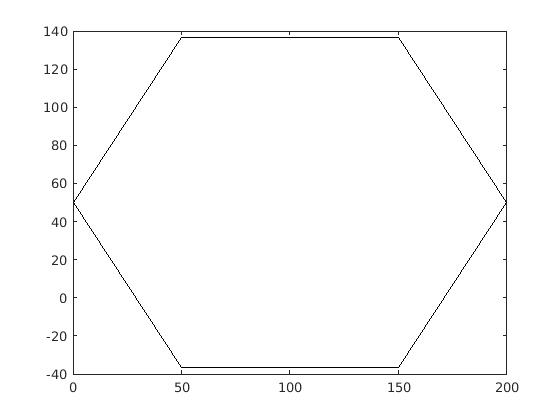

In [2]:
fDrawSector(100,100+50*i)

**Passo 03:** Crie uma função chamada **fDrawDeploy.m** com o segunte código. Ela servirá para desenhar o grid celular. Tal função servira para teros certeza que o posicionamento das ERBs estão corretos.

In [3]:
%%file fDrawDeploy.m
function fDrawDeploy(dR,vtBs)
% Desenha setores hexagonais
hold on;
for iBsD = 1 : length(vtBs)
    fDrawSector(dR,vtBs(iBsD));
end
% Plot BSs
plot(vtBs,'sk'); axis equal;
end

Created file '/home/labsim/EEC1714/fDrawDeploy.m'.


**Passo 04:** Inspecione e insira o código a seguir no editor do Matlab (salve com o nome **handson2_P2_1.m**). Nesse código, vamos criar um vetor com a posição das 7 ERBs. A posição é ajustada para que a referência, i.e., o ponto (0,0) seja o canto inferior esquerdo do grid. Também já criamos o grid com a dimensão especificada no hands-on.

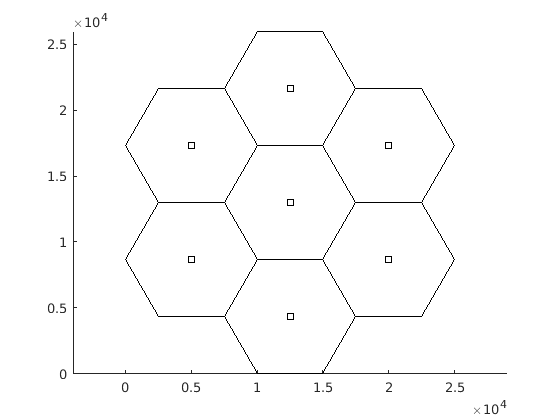

In [4]:
dR = 5e3; % Raio do Hexágono
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)

% Desenha setores hexagonais
fDrawDeploy(dR,vtBs)
axis equal;

## Prática 02: Cálculo e plot da potência recebida sem e com shadowing

Vamos escrever um código para o cálculo da potência recebida nos pontos de medição do REM de cada ERB, e também considerando a composição das 7 ERBs. Como especificado no hands-on, precisamos considerar que a potência recebida de cada ponto de medição é a maior potência recebida em relação às 7 ERBs.

**Passo 01:** Inspecione, insira o código a seguir no editor do Matlab (salve com o nome **handson2_p21.m**). Nesse código, vamos:

- Criar sete matrizes de distâncias relativas de cada ponto de medição e para cada ERB (matrizes **mtDistEachBs**). Aplicaremos o raio de segurança a essas distâncias;
- Com as distâncias, usaremos o modelo de Okumura-Hata para calcular a perda de percurso (matrizes **mtPldB**);
- Sortearemos baseado em uma distribiução Lognormal amostras independentes do Sombreamento para cada ponto de medição (matrizes **mtShadowing**);
- Com as matrizes de EIRP, da perda de percurso e do sombreamento, calcularemos a potência recebida de cada ERB em cada ponto de medição. Para cada ERB montaremos a matriz **mtPowerEachBSdBm**;
- Montaremos uma única matriz **mtPowerFinaldBm** com a maior potência recebida em cada ponto de medição;
- Plotaremos o REM de cada ERB e da composição das 7 ERBs.

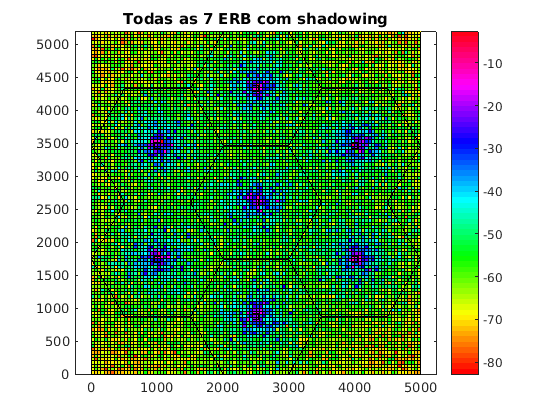

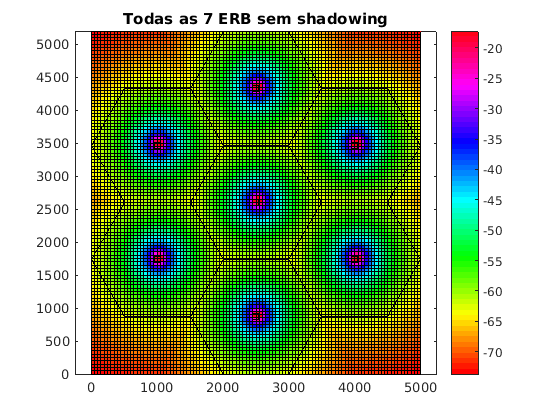

In [7]:
% Entrada de parâmetros
dR = 1e3;                                                  % Raio do Hexágono
dFc = 800;                                                 % Frequência da portadora
dSigmaShad = 8;                                            % Desvio padrão do sombreamento lognormal
% Cálculos de outras variáveis que dependem dos parâmetros de entrada
dPasso = ceil(dR/20);                                      % Resolução do grid: distância entre pontos de medição
dRMin = dPasso;                                            % Raio de segurança
dIntersiteDistance = 2*sqrt(3/4)*dR;                       % Distância entre ERBs (somente para informação)
dDimX = 5*dR;                                              % Dimensão X do grid
dDimY = 6*sqrt(3/4)*dR;                                    % Dimensão Y do grid
dPtdBm = 57;                                               % EIRP (incluindo ganho e perdas) (https://pt.slideshare.net/naveenjakhar12/gsm-link-budget)
dPtLinear = 10^(dPtdBm/10)*1e-3;                           % EIRP em escala linear
dHMob = 5;                                                 % Altura do receptor
dHBs = 30;                                                 % Altura do transmissor
dAhm = 3.2*(log10(11.75*dHMob)).^2 - 4.97;                 % Modelo Okumura-Hata: Cidade grande e fc  >= 400MHz
% Vetor com posições das BSs (grid Hexagonal com 7 células, uma célula central e uma camada de células ao redor)
vtBs = [ 0 ];
dOffset = pi/6;
for iBs = 2 : 7
    vtBs = [ vtBs dR*sqrt(3)*exp( j * ( (iBs-2)*pi/3 + dOffset ) ) ];
end
vtBs = vtBs + (dDimX/2 + j*dDimY/2);                        % Ajuste de posição das bases (posição relativa ao canto inferior esquerdo)
%
% Matriz de referência com posição de cada ponto do grid (posição relativa ao canto inferior esquerdo)
dDimY = ceil(dDimY+mod(dDimY,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
dDimX = ceil(dDimX+mod(dDimX,dPasso));                      % Ajuste de dimensão para medir toda a dimensão do grid
[mtPosx,mtPosy] = meshgrid(0:dPasso:dDimX, 0:dPasso:dDimY);
% Iniciação da Matriz de com a pontência de recebida máxima em cada ponto
% medido. Essa potência é a maior entre as 7 ERBs.
mtPowerFinaldBm = -inf*ones(size(mtPosy));
mtPowerFinalShaddBm = -inf*ones(size(mtPosy));
% Calcular O REM de cada ERB e aculumar a maior potência em cada ponto de medição
for iBsD = 1 : length(vtBs)                                 % Loop nas 7 ERBs
    % Matriz 3D com os pontos de medição de cada ERB. Os pontos são
    % modelados como números complexos X +jY, sendo X a posição na abcissa e Y, a posição no eixo das ordenadas
    mtPosEachBS = (mtPosx + j*mtPosy)-(vtBs(iBsD));
    mtDistEachBs = abs(mtPosEachBS);              % Distância entre cada ponto de medição e a sua ERB
    mtDistEachBs(mtDistEachBs < dRMin) = dRMin;             % Implementação do raio de segurança
    % Okumura-Hata (cidade urbana) - dB
    mtPldB = 69.55 + 26.16*log10(dFc) + (44.9 - 6.55*log10(dHBs))*log10(mtDistEachBs/1e3) - 13.82*log10(dHBs) - dAhm;
    % Shadowing independente em cada ponto
    mtShadowing = dSigmaShad*randn(size(mtPosy));
    % Potências recebidas em cada ponto de medição sem shadowing
    mtPowerEachBSdBm = dPtdBm - mtPldB;           
    % Potências recebidas em cada ponto de medição com shadowing
    mtPowerEachBSShaddBm = dPtdBm - mtPldB + mtShadowing;           
    % Cálulo da maior potência em cada ponto de medição sem shadowing
    mtPowerFinaldBm = max(mtPowerFinaldBm,mtPowerEachBSdBm);
    % Cálulo da maior potência em cada ponto de medição com shadowing
    mtPowerFinalShaddBm = max(mtPowerFinalShaddBm,mtPowerEachBSShaddBm);
end
% Plot da REM de todo o grid (composição das 7 ERBs) sem shadowing
figure;
pcolor(mtPosx,mtPosy,mtPowerFinaldBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB sem shadowing']);
%
% Plot da REM de todo o grid (composição das 7 ERBs) sem shadowing
figure;
pcolor(mtPosx,mtPosy,mtPowerFinalShaddBm);
colormap(hsv);
colorbar;
fDrawDeploy(dR,vtBs);
axis equal;
title(['Todas as 7 ERB com shadowing']);

**A execução do código resulta em:**
1. Dois mapas REMs mostrando o grid celular e a potência recebida nos pontos de medição para as 7 ERBS;
2. Foi utilizado um colormap diferente da primeria parte do hands-on para diferenciar melhor os níveis de potência e as diferentes cores que o representa;
2. A situação com e sem sombreamento estão identificadas no título de cada gráfico;
3. Note que a distribuição de potência deixa de ser uniforme e radial quando o sombreamento está presente.

**Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

##  Entrega 1: Modelagem e avaliação da inclusão de microcélulas


Uma solução tecnológica para tratar problemas de cobertura é o uso de repetidores (microcélulas, picocélulas) com intuito de estender o alcance de uma estrutura macrocelular (torres altas e com alta potência). Considere o uso de microcélulas com as seguintes características:

  - Potência de transmissão: 0.1 W
  - Perda de percurso: PL = 55 + 38 $\cdot$ log$_{10}$(d)+ (24.5 + $\frac{1.5*f}{925}$)*log$_{10}$(f), com d em km e f em MHz;
   
O sistema não é multi-conectividade, i.e., a potência de um ponto NÃO é a SOMA da potência da melhor macrocélula com a microcélula. Assim, como um usuário está conectado ou a macrocélula ou a microcélula, ao final você terá somente uma matriz de potências recebidas.

A figura a seguir mostra um exemplo de posicionamento de seis microcélulas. Será que algumas dessas posições são realmente as mais aconselhadas para resolver o problema da Outage?

![fig_shadcorr_mod_zoom_300](../FIGS/HD_01_MATLAB/microcelulas.png)

Considere -90 dBm como potência mínima de operação, i.e., um usuário (ou ponto no grid) é bloqueado se sua potência recebida for menor que esse valor. Outra consideração importante é que os usuários estão conectados a melhor estação rádio base. Faça os mapas com resolução espacial de 50 m. Se necessário, essa resolução pode ser diminuída, para melhor visualização da cobertura das microcélulas.

- Contrua um back-end com métodos para realizar os cálculos necessários:
  - Montar o grid celular, considerando somente o grid de pontos que estão dentro dos hexágonos (novo), i.e., escolher uma cor (valor numérico da matriz) que diferencie a região fora dos hexagonos da região dentro; 
  - Calcular a potência recebida em cada ponto do grid;
  - Calcular os pontos que estão em outage e mostrar no grid;
  - Calcular os pontos que estão em outage e mostrar a porcentagem de pontos em outage;
  - Adicionar microcélulas e recalcular a potência recebida em cada ponto do grid e a outage;
- Construa um front-end para visualização dos resultados. O front-end precisa ter:
  - Entrada dos parâmetros principais das macrocélulas (sem incluir seu posicionamento);
  - Entrada dos parâmetros principais das microcélulas, incluindo sua posição (um pop-up);
  - Mapa com a cobertura do sistema celular (somente das macrocélulas);
  - Mapa com a cobertura do sistema celular (com macrocélulas e microcélulas);  
  - Campo com a outage (em %) para o cenário somente com macrocélulas;
  - Campo com a outage (em %) para o cenário com macrocélulas e microcélulas adicionadas;
  - Botão para adição de microcélulas;
  - Botão para reset dos dados do campo de adição de microcélulas;
  - Botão para calcular os resultados (atualização do mapa e dos campos de outage);
  - Botão em cada sessão de microcélula par remover microcéula (incluindo os resultados);
  - (Extra) Se possível, calcule o posicionamento da microcélula ao clicar no mapa.

Com o uso do software, realize a investigação a seguir.

Seu alvo é analisar 3 cenários:

  - (i) Sistema somente com perda de percurso (sem shadowing), f = 800 MHz, ht = 32m e hr= 1,5m, raio do hexágono 500m;
  - (ii) Sistema somente com perda de percurso (sem shadowing), f = 1800 MHz, ht = 32m e hr= 1,5m, raio do hexágono 500m;
  - (iii) Sistema somente com perda de percurso (sem shadowing), f = 2100 MHz, ht = 32m e hr= 1,5m, raio do hexágono 500m;
  

Prepare um primeiro conjunto de resultados, ainda sem microcélulas, e com a potência da macrocélula igual a 21 dBm. Eles são:

 - REMs identificando a área de Outage no mapa para as três frequências. Analise esses gráficos e decida qual o melhor posicionamento da suas seis microcélulas.
 
 - Discuta se as áreas de outage mudaram, e se essa mudança a fez escolher posicionamento diferentes para microcélulas, dependendo da frequência da portadora;

De posse do primeiro conjunto de resultados, posicione seis (somente seis) microcélulas nos pontos estratégicos escolhidos por você.

Compare os resultados com a situação sem a microcélulas. Quais as principais observações e diferenças?

Agora com as microcélulas inteligentemente posicionadas por você, colha os valores de outage com e sem microcélula para cada cenário e os analise.
 